# Solution using `scikit-fem` and an external tagged mesh

Similarly to [fenics-gmsh.ipynb](../fenics-gmsh/fenics-gmsh.ipynb), we define the mesh using `gmsh` in the notebook [create-interval-mesh.ipynb](../fenics-gmsh/create-interval-mesh.ipynb) and we solve the problem without knowing the geometry.

In [1]:
import skfem
import skfem.visuals.matplotlib
from skfem.helpers import grad, dot
import numpy as np

## Load a mesh

In [2]:
mesh = skfem.mesh.Mesh.load("../fenics-gmsh/interval.msh")
mesh.subdomains.pop("gmsh:bounding_entities", None)
mesh

Failure to orient a boundary.
Failure to orient a boundary.


<skfem MeshLine1 object>
  Number of elements: 100
  Number of vertices: 101
  Number of nodes: 101
  Named subdomains [# elements]: L [50], R [50]
  Named boundaries [# facets]: B_L [1], B_R [1]

In [3]:
mesh.subdomains

{'L': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       dtype=int32),
 'R': array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       dtype=int32)}

This mesh has two subdomains: "L" (left subdomain) and "R" (right subdomain). It also has two boundaries: "B_L" (at x=0) and "B_R" (at x=1).

In [4]:
mesh.subdomains

{'L': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       dtype=int32),
 'R': array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       dtype=int32)}

## Solve linear problem

We follow [skfem-simple.ipynb](../skfem-simple/skfem-simple.ipynb) for most of this notebook.

In [5]:
# For trial and test function
basis_p1 = skfem.Basis(mesh=mesh, elem=skfem.ElementLineP1())

# For material parameter sigma
basis_p0 = skfem.Basis(mesh=mesh, elem=skfem.ElementDG(skfem.ElementLineP0()))

We define the parameter `sigma` depending on the tags.

In [6]:
mesh.subdomains

{'L': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       dtype=int32),
 'R': array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       dtype=int32)}

In [7]:
s = mesh.subdomains["L"]
s

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
      dtype=int32)

In [8]:
sigma_values = {
    "L": 1,  # value is 1 on left subdomain
    "R": 2,  # value is 2 on right subdomain
}
sigma = basis_p0.zeros()
for sd in mesh.subdomains:
    sigma[basis_p0.get_dofs(elements=sd)] = sigma_values[sd]

In [9]:
# aa = basis_p0.zeros()
# aa[11] = 8
# aa = basis_p0.interpolate(aa)

We define the variational forms.

In [10]:
@skfem.BilinearForm
def stifness_matrix(u, v, w):
    return - w.sigma * dot(grad(u), grad(v))

In [11]:
@skfem.LinearForm
def l(v, _):
    return 0 * v

In [12]:
S = stifness_matrix.assemble(basis_p1, sigma=basis_p0.interpolate(sigma))

In [13]:
L = l.assemble(basis_p1)

We apply the boundary conditions

In [14]:
u = basis_p1.zeros()
u[basis_p1.get_dofs("B_L")] = 0.
u[basis_p1.get_dofs("B_R")] = 10.

### Solve linear equations and plot

In [15]:
u = skfem.solve(*skfem.condense(S, L, x=u, D=basis_p1.get_dofs()))

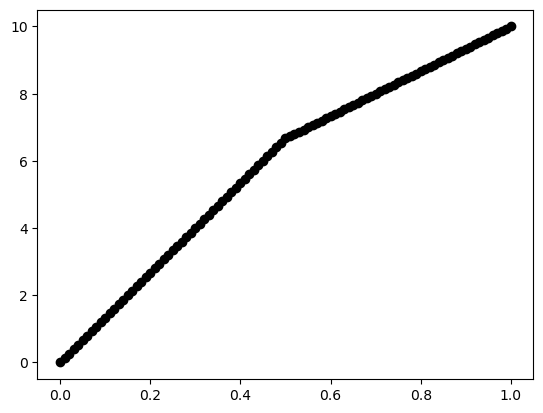

In [16]:
skfem.visuals.matplotlib.plot(mesh, u);

## Comparing analytical and FEM solutions

In [17]:
y = np.where(mesh.p[0]<0.5, mesh.p[0] * 40 / 3, (mesh.p[0] * 20 / 3) + (10/3))

In [18]:
np.linalg.norm(y - u)

np.float64(9.065226133860604e-13)

In [19]:
import matplotlib.pyplot as plt

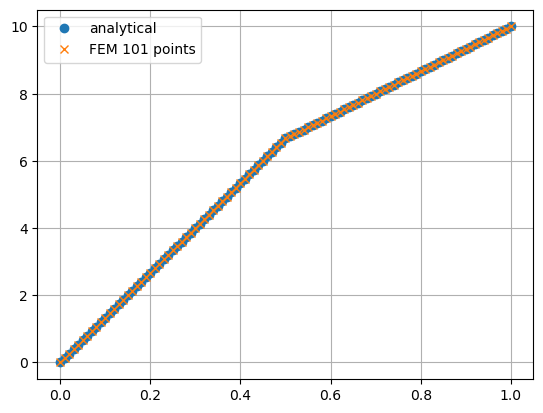

In [20]:
plt.plot(mesh.p[0], y, "o", label="analytical")
plt.plot(mesh.p[0], u, "x", label="FEM 101 points")
plt.legend()
plt.grid()
plt.show()